In [1]:
import stylia
import pandas as pd
import networkx as nx
import numpy as np
import collections
import matplotlib.pyplot as plt

df = pd.read_csv("../data/finalScreen.tsv", sep="\t")
df = df[df["nUniq"] >= 2]
db = df[df["l2fc"] >= 2.3]
db = db[db["l2fcM"] >= 1]
db = db[db["ml10p"] > -np.log10(0.05)]
db = db[db["ml10adjP"] > -np.log10(2.5)]
db = db[db["rankRel"] < 500]

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [2]:
my_frags = ["C186", "C027", "C391"]
my_prots = ["SLC29A1", "DDB1", "CDK2", "CDK16"]
my_pairs = [
    ("C186", "DDB1"),
    ("C027", "SLC29A1"),
    ("C391", "CDK2"),
    ("C391", "CDK16")
]

prot_counts = collections.defaultdict(int)
frag_counts = collections.defaultdict(int)
G = nx.Graph()

for r in db[["fragId", "geneName", "l2fcM"]].values:
    prot_counts[r[1]] += 1
    frag_counts[r[0]] += 1

for r in db[["fragId", "geneName", "l2fcM"]].values:
    if prot_counts["geneName"] >= 10:
        continue
    G.add_edge(r[0], r[1], weight=r[2])

In [3]:
import csv

pid2name = {}
with open("../data/pid2name_primary.tsv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for r in reader:
        pid2name[r[0]] = r[1]


prot2idg = {}
with open("../data/pharos_protein_category.tsv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for r in reader:
        if r[0] not in pid2name:
            continue
        prot2idg[pid2name[r[0]]] = r[1]

for p in my_prots:
    print(p, prot2idg[p])

SLC29A1 Tclin
DDB1 Tbio
CDK2 Tchem
CDK16 Tchem


('C186', 'DDB1') 2.137866709483578
('C027', 'SLC29A1') 2.0443087493909395
('C391', 'CDK2') 2.136253741503981
('C391', 'CDK16') 2.1645462064663734


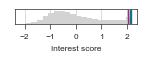

In [109]:
from scipy.stats import percentileofscore
from stylia  import NamedColors
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

colors = {
    "DDB1": NamedColors().red,
    "CDK16": NamedColors().blue,
    "CDK2": NamedColors().blue,
    "SLC29A1": NamedColors().purple,
    "C027": NamedColors().purple,
    "C391": NamedColors().blue,
    "C186": NamedColors().red
}

fig, axs = stylia.create_figure(1, 1, width = stylia.TWO_COLUMNS_WIDTH*0.2, height=stylia.TWO_COLUMNS_WIDTH*0.08)

ax = axs.next()

pid_c = {}
for pid in list(set(db["geneName"])):
    v = []
    for k,w in dict(G[pid]).items():
        v += [w["weight"]]
    pid_c[pid] = np.sum(v)
    
fid_c = {}
for fid in list(set(db["fragId"])):
    v = []
    for k,w in dict(G[fid]).items():
        v += [w["weight"]]
    fid_c[fid] = np.sum(v)
    
pairs_c = {}
for p in db[["fragId", "geneName", "l2fcM"]].values:
    v = p[2]/np.sqrt(fid_c[p[0]]*pid_c[p[1]])
    pairs_c[(p[0], p[1])] = v

values = np.array([v for _,v in pairs_c.items()]).reshape(-1,1)
trf = PowerTransformer()
values = trf.fit_transform(values)[:,0]

ax.hist(values, bins=20, lw=0, color=NamedColors().gray)

ylim = ax.get_ylim()

for p in my_pairs:
    x = trf.transform([[pairs_c[p]]])[0,0]
    print(p, x)
    ax.plot([x, x], [0,ylim[1]], color=colors[p[0]], lw=1)

ax.set_yticks([])
ax.set_xticks([-2, -1, 0, 1, 2])
stylia.label(ax, title="", ylabel="", xlabel="Interest score")

plt.tight_layout()
stylia.save_figure("test.pdf")
stylia.save_figure("test.png")


In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from scipy.spatial.distance import pdist
import h5py

def pid2namer(x):
    if x in pid2name:
        return pid2name[x]
    else:
        return x

with h5py.File("../data/Xp_panther.h5", "r") as f:
    keys = np.array([pid2namer(x.decode()) for x in f["Keys"][:]])
    matrix = f["Values"][:]

mask = []
for k in keys:
    if k in set(db["geneName"]):
        mask += [True]
    else:
        mask += [False]
mask = np.array(mask)

keys = keys[mask]
matrix = matrix[mask]

distances = pdist(matrix, metric='euclidean')

# Perform hierarchical clustering using the 'ward' method
linked = linkage(distances, method='ward', optimal_ordering=True)

# Obtain the optimal ordering of the data points based on the hierarchical clustering
order = leaves_list(linked)

# Sort the matrix rows based on the optimal order
sorted_matrix = matrix[order]

In [106]:
keys = np.array(keys)[order]

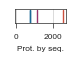

In [107]:
fig, axs = stylia.create_figure(1, 1, width = stylia.TWO_COLUMNS_WIDTH*0.2*0.5, height=stylia.TWO_COLUMNS_WIDTH*0.08)

ax = axs.next()

for i, k in enumerate(keys):
    if k in my_prots:
        ax.plot([i, i], [0, 1], color=colors[k], lw=1)
ax.set_yticks([])
ax.set_xlim(-50, len(keys))

stylia.label(ax, title="", ylabel="", xlabel="Prot. by seq.")
plt.tight_layout()
stylia.save_figure("test_1.pdf")
stylia.save_figure("test_1.png")

In [85]:
import joblib
Xt = joblib.load("../data/Xt_figure1.joblib")

df = pd.read_csv("../data/finalScreen.tsv", sep="\t")
fids = sorted(set(df["fragId"]))
idxs = []
for fid in sorted(set(db["fragId"])):
    idxs += [fids.index(fid)]
Xt = Xt[idxs]

In [102]:
distances = pdist(Xt, metric='euclidean')

# Perform hierarchical clustering using the 'ward' method
linked = linkage(distances, method='ward', optimal_ordering=True)

# Obtain the optimal ordering of the data points based on the hierarchical clustering
order = leaves_list(linked)

# Sort the matrix rows based on the optimal order
sorted_Xt = Xt[order]

In [103]:
fids = np.array(fids)[order]

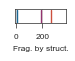

In [104]:
fig, axs = stylia.create_figure(1, 1, width = stylia.TWO_COLUMNS_WIDTH*0.2*0.5, height=stylia.TWO_COLUMNS_WIDTH*0.08)

ax = axs.next()

for i, k in enumerate(fids):
    if k in my_frags:
        ax.plot([i, i], [0, 1], color=colors[k], lw=1)
ax.set_yticks([])
ax.set_xlim(-10, len(fids))

stylia.label(ax, title="", ylabel="", xlabel="Frag. by struct.")
plt.tight_layout()
stylia.save_figure("test_2.pdf")
stylia.save_figure("test_2.png")